In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [8]:
# Charger le fichier avec le chemin corrigé
file_path = r"transactions.csv"
df = pd.read_csv(file_path)

# Vérifier les premières lignes pour confirmer le chargement
print(df.head())

  TransactionID AccountID  TransactionAmount      TransactionDate  \
0      TX000001   AC00128              14.09  2023-04-11 16:29:14   
1      TX000002   AC00455             376.24  2023-06-27 16:44:19   
2      TX000003   AC00019             126.29  2023-07-10 18:16:08   
3      TX000004   AC00070             184.50  2023-05-05 16:32:11   
4      TX000005   AC00411              13.45  2023-10-16 17:51:24   

  TransactionType   Location DeviceID      IP Address MerchantID Channel  \
0           Debit  San Diego  D000380  162.198.218.92       M015     ATM   
1           Debit    Houston  D000051     13.149.61.4       M052     ATM   
2           Debit       Mesa  D000235  215.97.143.157       M009  Online   
3           Debit    Raleigh  D000187  200.13.225.150       M002  Online   
4          Credit    Atlanta  D000308    65.164.3.100       M091  Online   

   CustomerAge CustomerOccupation  TransactionDuration  LoginAttempts  \
0           70             Doctor                   81 

In [10]:
#missing values
df.isnull().sum()

TransactionID              0
AccountID                  0
TransactionAmount          0
TransactionDate            0
TransactionType            0
Location                   0
DeviceID                   0
IP Address                 0
MerchantID                 0
Channel                    0
CustomerAge                0
CustomerOccupation         0
TransactionDuration        0
LoginAttempts              0
AccountBalance             0
PreviousTransactionDate    0
dtype: int64

In [12]:
# Check for duplicates
df.duplicated().sum()

0

In [14]:
df['CustomerAge'].mean()

44.673964968152866

In [16]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

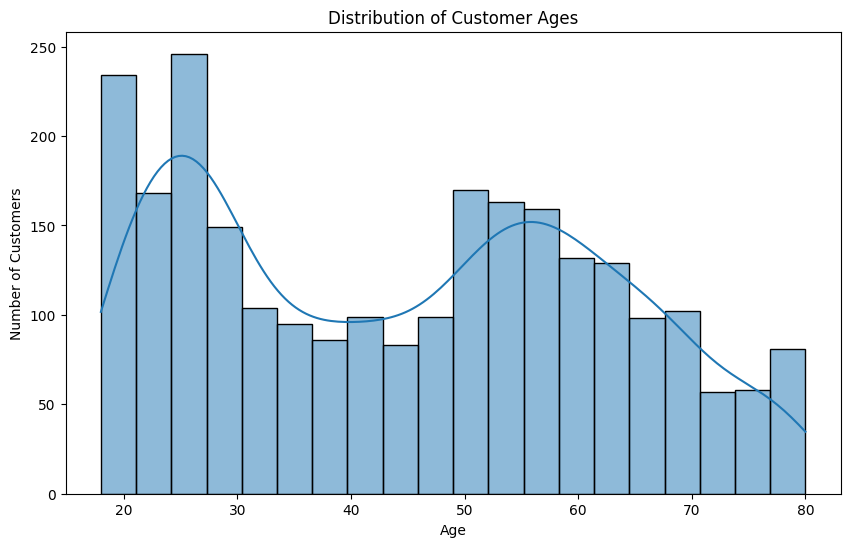

In [18]:
# Show the aga distribution

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['CustomerAge'], bins=20, kde=True) 
plt.title('Distribution of Customer Ages')
plt.xlabel('Age')
plt.ylabel('Number of Customers')
plt.show()

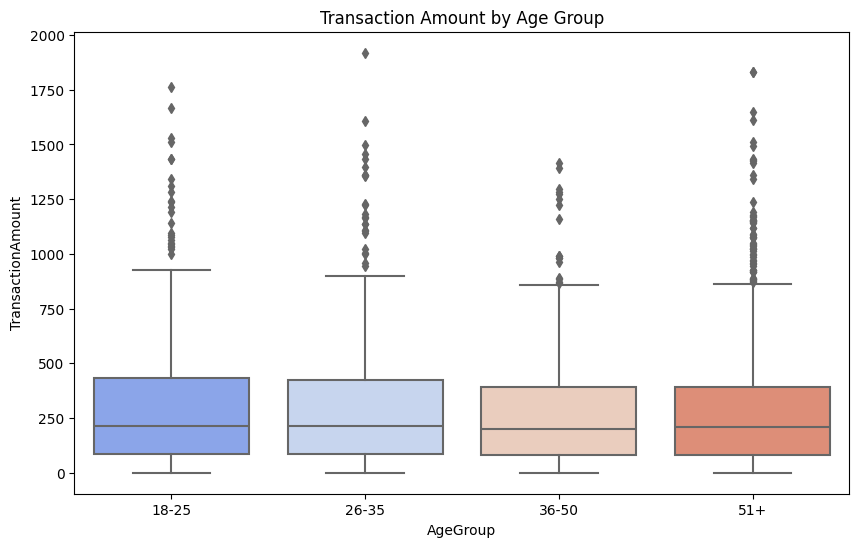

In [20]:
df['AgeGroup'] = pd.cut(df['CustomerAge'], bins=[0, 25, 35, 50, 100], labels=['18-25', '26-35', '36-50', '51+'])
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='AgeGroup', y='TransactionAmount', palette='coolwarm')
plt.title("Transaction Amount by Age Group")
plt.show()

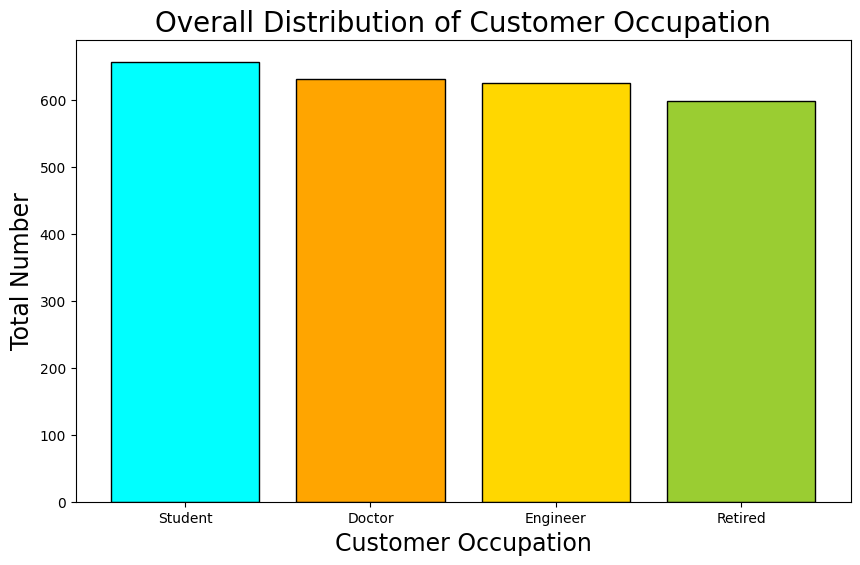

In [24]:
customer_occupation_counts = df['CustomerOccupation'].value_counts()
customer_occupation_counts

plt.figure(figsize=(10,6))

colors=['aqua', 'orange', 'gold', 'yellowgreen']

plt.bar(customer_occupation_counts.index, customer_occupation_counts.values, color=colors[:len(customer_occupation_counts)], edgecolor='black')

plt.xlabel('Customer Occupation', fontsize=17)
plt.ylabel('Total Number', fontsize=17)
plt.title('Overall Distribution of Customer Occupation', fontsize=20)

plt.show()

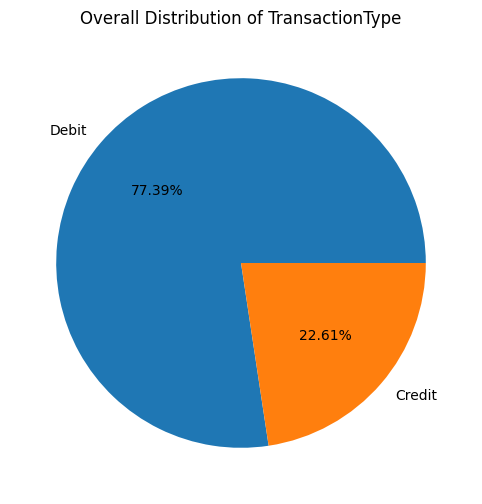

In [26]:
debitcard_counts = df[df['TransactionType']=='Debit']['TransactionType'].count()
creditcard_counts = df[df['TransactionType']=='Credit']['TransactionType'].count()

plt.figure(figsize=(10,6))

index_values = [debitcard_counts, creditcard_counts]
index_labels = ['Debit', 'Credit']

plt.pie(index_values, labels = index_labels, autopct='%2.2f%%')

plt.title('Overall Distribution of TransactionType')

plt.show()

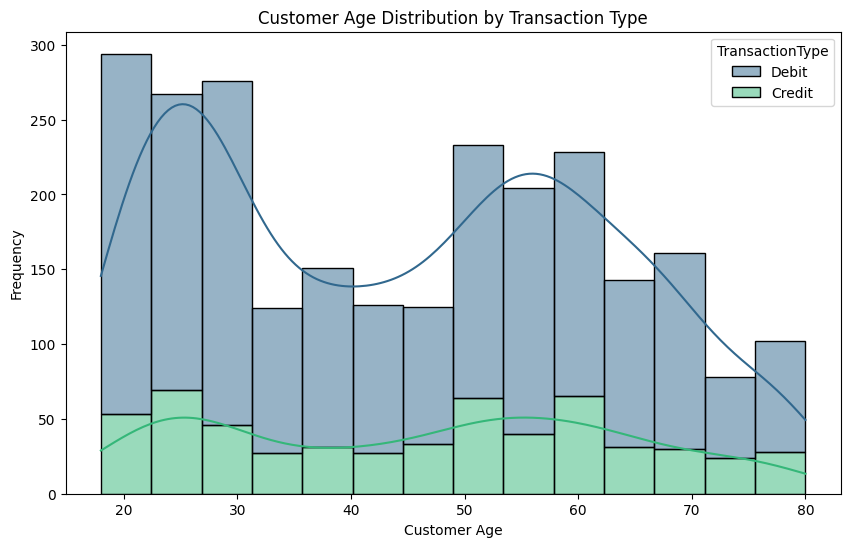

In [28]:
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='CustomerAge', hue='TransactionType', multiple='stack', palette='viridis', kde=True)
plt.title('Customer Age Distribution by Transaction Type')
plt.xlabel('Customer Age')
plt.ylabel('Frequency')
plt.show()

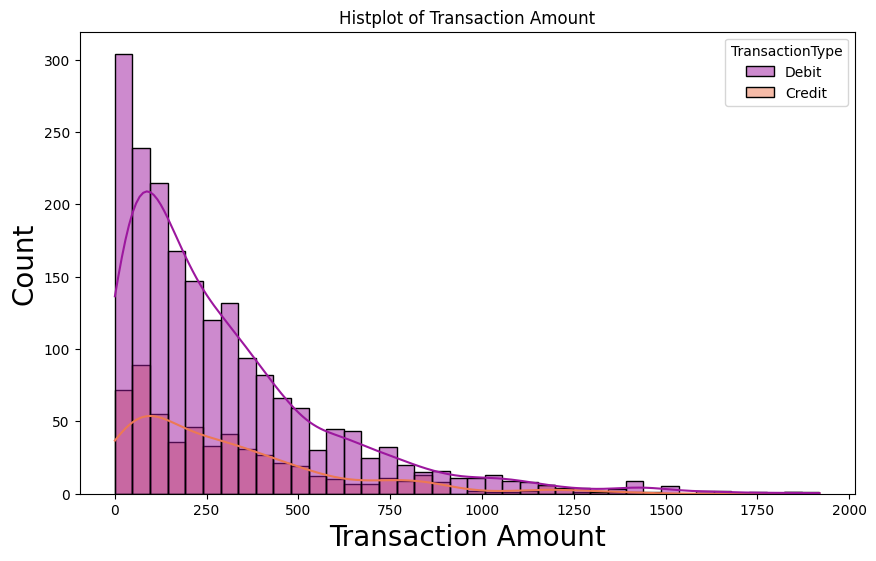

In [30]:
plt.figure(figsize=(10,6))

plt.xlabel("Transaction Amount", fontsize=20)
plt.ylabel("Count", fontsize=20)

plt.title("Histplot of Transaction Amount")

sns.histplot(data=df, x="TransactionAmount", kde=True, hue='TransactionType', palette='plasma')

plt.show()

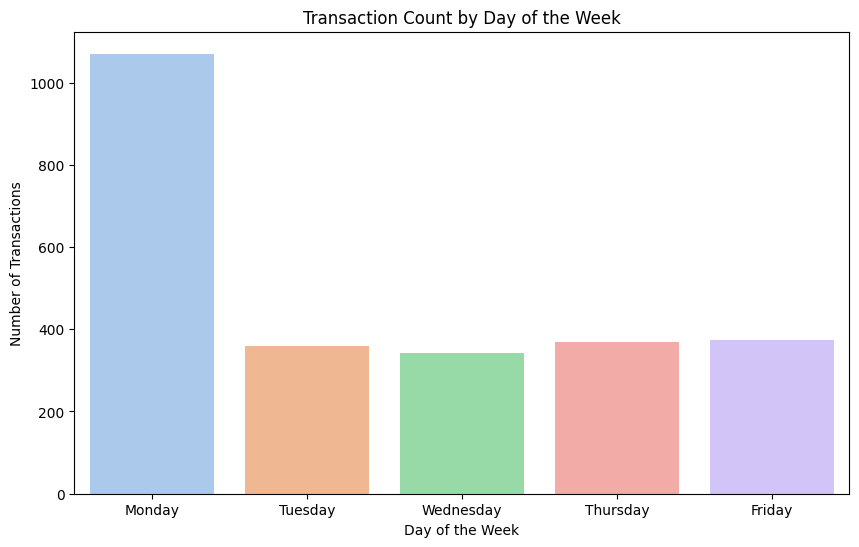

In [32]:
# Convert TransactionDate to datetime
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

# Extract the day of the week
df['DayOfWeek'] = df['TransactionDate'].dt.day_name()

# Plot transaction count by day of the week
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='DayOfWeek', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], palette='pastel')
plt.title('Transaction Count by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Transactions')
plt.show()

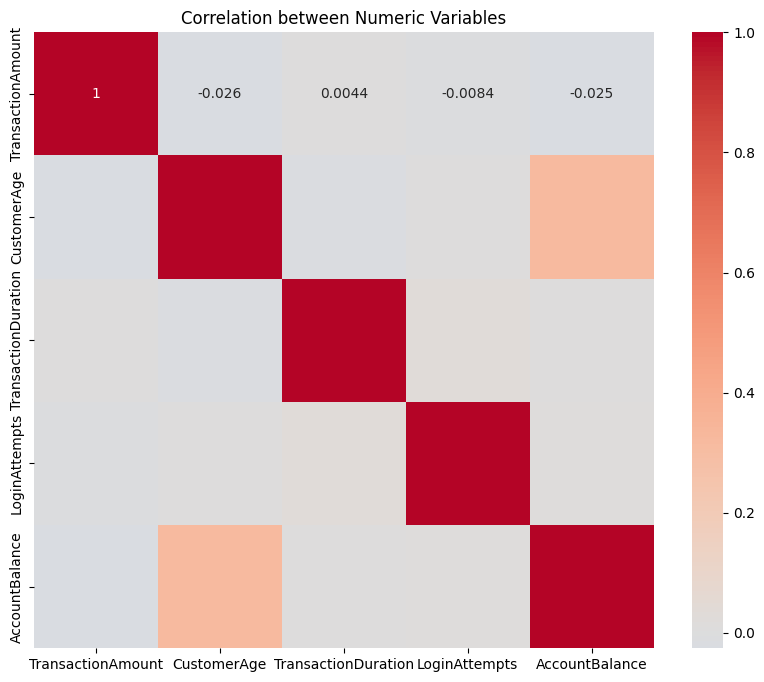

In [36]:
plt.figure(figsize=(10, 8))
numeric_cols = df.select_dtypes(include=[np.number]).columns
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Numeric Variables')
plt.show()

In [38]:
!pip install folium

In [39]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [47]:
import folium
from geopy.geocoders import Nominatim

In [48]:
# Calculate the approximate latitude/ longitude coordinates for unique locations in the data
unique_locations = df['Location'].unique()
location_coords = {}

# Initialize geolocator
geolocator = Nominatim(user_agent="location_mapper")

# Get approximate coordinates for each unique location
for location in unique_locations:
    try:
        loc = geolocator.geocode(location)
        if loc:
            location_coords[location] = (loc.latitude, loc.longitude)
        else:
            print(f"Coordinates not found for {location}")
    except Exception as e:
        print(f"Error fetching coordinates for {location} : {e}")

# Add the coordinates to the DataFrame
df['Coordinates'] = df['Location'].map(location_coords)

In [52]:
# Iniitialize the Folium map centered at an approximate central point
initial_coords = list(location_coords.values())[0] if location_coords else [0, 0]
mymap = folium.Map(location = initial_coords, zoom_start=5)

for _, row in df.iterrows():
    if row['Coordinates']:
        folium.Marker(
            location=row['Coordinates'],
            popup=f"TransactionID: {row['TransactionID']}<br>Amount: ${row['TransactionAmount']}",
            tooltip=row['Location']
        ).add_to(mymap)

mymap.save('./saved-map.html')
mymap

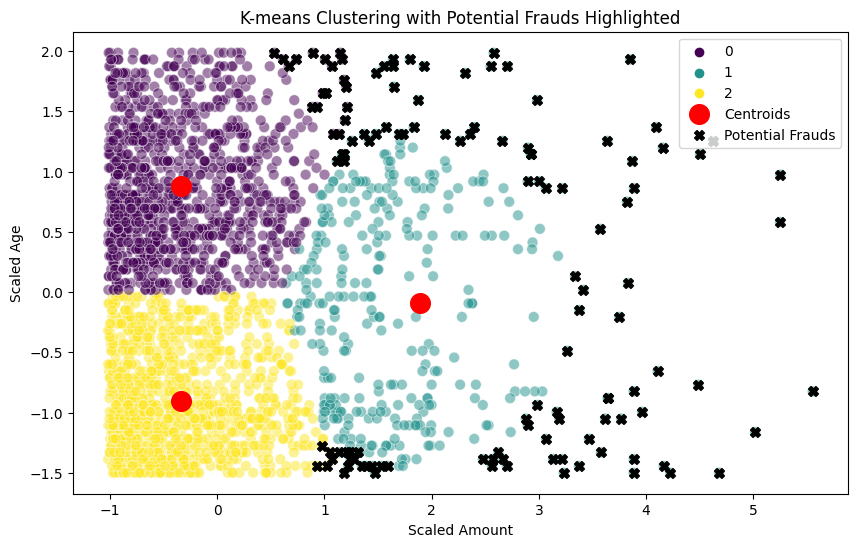

Number of potential frauds detected: 126


In [51]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


X = df[['TransactionAmount', 'CustomerAge']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Add labels to the dataset
df['KMeans_Cluster'] = kmeans_labels


# Calculate distance of each point to its assigned cluster centroid
distances = np.linalg.norm(X_scaled - kmeans.cluster_centers_[kmeans_labels], axis=1)

# Define a threshold (e.g., top 5% farthest from centroids)
threshold = np.percentile(distances, 95)  # Change this value as needed

# Flag points above the threshold as potential frauds
df['Potential_Fraud'] = distances > threshold

# Separate fraudulent and non-fraudulent transactions
frauds = df[df['Potential_Fraud']]
non_frauds = df[~df['Potential_Fraud']]

# Plot with frauds highlighted
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=kmeans_labels, palette='viridis', s=60, alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', label='Centroids')
plt.scatter(X_scaled[distances > threshold, 0], X_scaled[distances > threshold, 1], 
            color='black', s=50, label='Potential Frauds', marker='X')
plt.title('K-means Clustering with Potential Frauds Highlighted')
plt.xlabel('Scaled Amount')
plt.ylabel('Scaled Age')
plt.legend()
plt.show()

# Output the number of frauds detected
print(f"Number of potential frauds detected: {len(frauds)}")

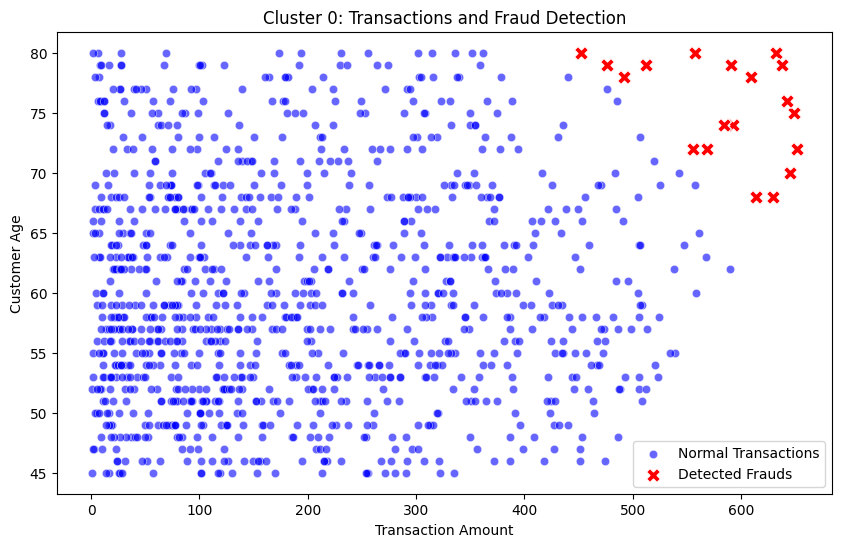

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data for Cluster 0
cluster_0_data = df[df['KMeans_Cluster'] == 0]
fraud_data_cluster_0 = cluster_0_data[cluster_0_data['Potential_Fraud'] == True]

# Scatter plot with frauds highlighted in Cluster 0
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cluster_0_data, x='TransactionAmount', y='CustomerAge', color='blue', label='Normal Transactions', alpha=0.6)
sns.scatterplot(data=fraud_data_cluster_0, x='TransactionAmount', y='CustomerAge', color='red', label='Detected Frauds', s=100, marker='X')
plt.title('Cluster 0: Transactions and Fraud Detection')
plt.xlabel('Transaction Amount')
plt.ylabel('Customer Age')
plt.legend()
plt.show()

In [67]:
# Filter flagged transactions in Cluster 0
cluster_0_frauds = df[(df['KMeans_Cluster'] == 0) & (df['Potential_Fraud'])]
print(cluster_0_frauds)

     TransactionID AccountID  TransactionAmount     TransactionDate  \
37        TX000038   AC00202             649.28 2023-03-02 17:53:32   
263       TX000264   AC00319             512.81 2023-07-19 16:57:01   
365       TX000366   AC00092             632.69 2023-09-12 16:28:38   
537       TX000538   AC00311             629.82 2023-07-17 16:22:23   
838       TX000839   AC00007             637.75 2023-07-24 16:07:05   
1002      TX001003   AC00062             476.63 2023-07-25 17:17:49   
1125      TX001126   AC00063             592.82 2023-09-14 17:25:49   
1152      TX001153   AC00012             590.57 2023-06-28 16:07:37   
1244      TX001245   AC00202             642.68 2023-05-25 16:45:31   
1304      TX001305   AC00083             609.52 2023-07-28 16:03:27   
1330      TX001331   AC00078             614.03 2023-05-08 16:37:14   
1339      TX001340   AC00175             557.41 2023-04-14 16:52:23   
1442      TX001443   AC00266             452.80 2023-11-24 16:45:11   
1443  

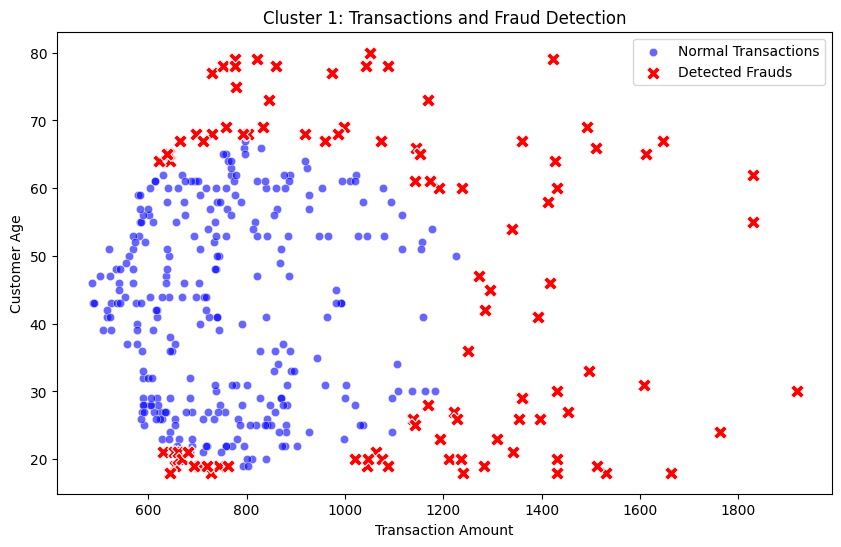

In [69]:
# Filter data for Cluster 1
cluster_1_data = df[df['KMeans_Cluster'] == 1]
fraud_data_cluster_1 = cluster_1_data[cluster_1_data['Potential_Fraud'] == True]

# Scatter plot with frauds highlighted in Cluster 1
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cluster_1_data, x='TransactionAmount', y='CustomerAge', color='blue', label='Normal Transactions', alpha=0.6)
sns.scatterplot(data=fraud_data_cluster_1, x='TransactionAmount', y='CustomerAge', color='red', label='Detected Frauds', s=100, marker='X')
plt.title('Cluster 1: Transactions and Fraud Detection')
plt.xlabel('Transaction Amount')
plt.ylabel('Customer Age')
plt.legend()
plt.show()

In [71]:
# Filter flagged transactions in Cluster 1
cluster_1_frauds = df[(df['KMeans_Cluster'] == 1) & (df['Potential_Fraud'])]
print(cluster_1_frauds)

     TransactionID AccountID  TransactionAmount     TransactionDate  \
74        TX000075   AC00265            1212.51 2023-10-04 16:36:29   
85        TX000086   AC00098            1340.19 2023-09-29 17:22:10   
138       TX000139   AC00405             997.43 2023-11-22 16:07:19   
141       TX000142   AC00114            1049.92 2023-10-23 16:50:33   
146       TX000147   AC00385             973.39 2023-08-30 17:23:20   
...            ...       ...                ...                 ...   
2380      TX002381   AC00098            1173.74 2023-09-25 16:44:52   
2382      TX002383   AC00119             761.73 2023-09-11 17:15:04   
2403      TX002404   AC00111            1493.00 2023-06-07 17:05:41   
2414      TX002415   AC00028            1664.33 2023-09-25 17:11:19   
2446      TX002447   AC00014             719.76 2023-03-30 17:50:23   

     TransactionType          Location DeviceID       IP Address MerchantID  \
74             Debit      Indianapolis  D000231     193.83.0.183    

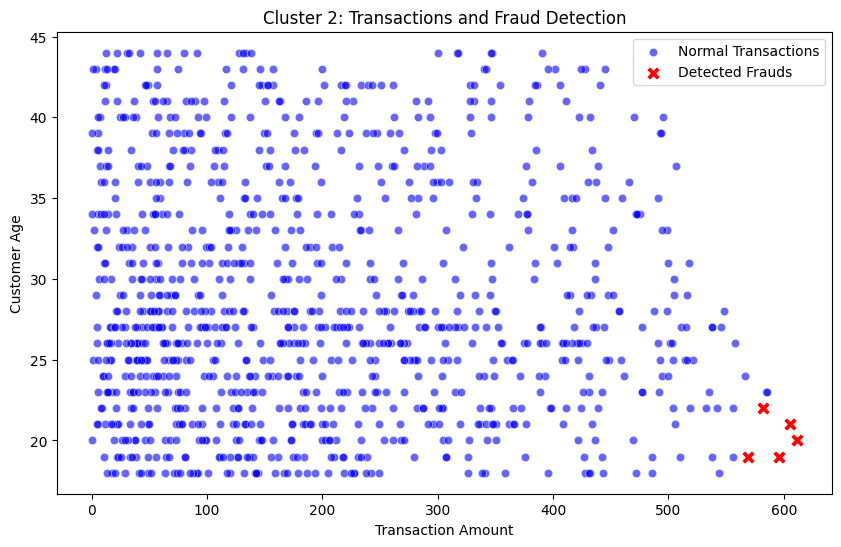

In [73]:
# Filter data for Cluster 2
cluster_2_data = df[df['KMeans_Cluster'] == 2]
fraud_data_cluster_2 = cluster_2_data[cluster_2_data['Potential_Fraud'] == True]

# Scatter plot with frauds highlighted in Cluster 1
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cluster_2_data, x='TransactionAmount', y='CustomerAge', color='blue', label='Normal Transactions', alpha=0.6)
sns.scatterplot(data=fraud_data_cluster_2, x='TransactionAmount', y='CustomerAge', color='red', label='Detected Frauds', s=100, marker='X')
plt.title('Cluster 2: Transactions and Fraud Detection')
plt.xlabel('Transaction Amount')
plt.ylabel('Customer Age')
plt.legend()
plt.show()

In [75]:
# Filter flagged transactions in Cluster 2
cluster_2_frauds = df[(df['KMeans_Cluster'] == 2) & (df['Potential_Fraud'])]
print(cluster_2_frauds)

     TransactionID AccountID  TransactionAmount     TransactionDate  \
227       TX000228   AC00115             581.65 2023-01-09 16:54:58   
454       TX000455   AC00264             611.11 2023-10-18 18:32:31   
1142      TX001143   AC00331             568.88 2023-02-10 16:28:47   
1233      TX001234   AC00014             605.42 2023-06-13 16:10:27   
1265      TX001266   AC00176             595.91 2023-08-10 18:39:04   

     TransactionType     Location DeviceID      IP Address MerchantID Channel  \
227            Debit       Boston  D000666   80.92.209.207       M009     ATM   
454            Debit      Detroit  D000215  141.201.46.191       M045     ATM   
1142           Debit    Nashville  D000321    213.15.9.253       M076  Branch   
1233           Debit         Mesa  D000488   25.188.196.47       M085     ATM   
1265          Credit  San Antonio  D000063  200.136.146.93       M085     ATM   

      ...  CustomerOccupation TransactionDuration  LoginAttempts  \
227   ...         

Unique cluster labels: [-1  0  1  2]
Number of detected frauds: 31


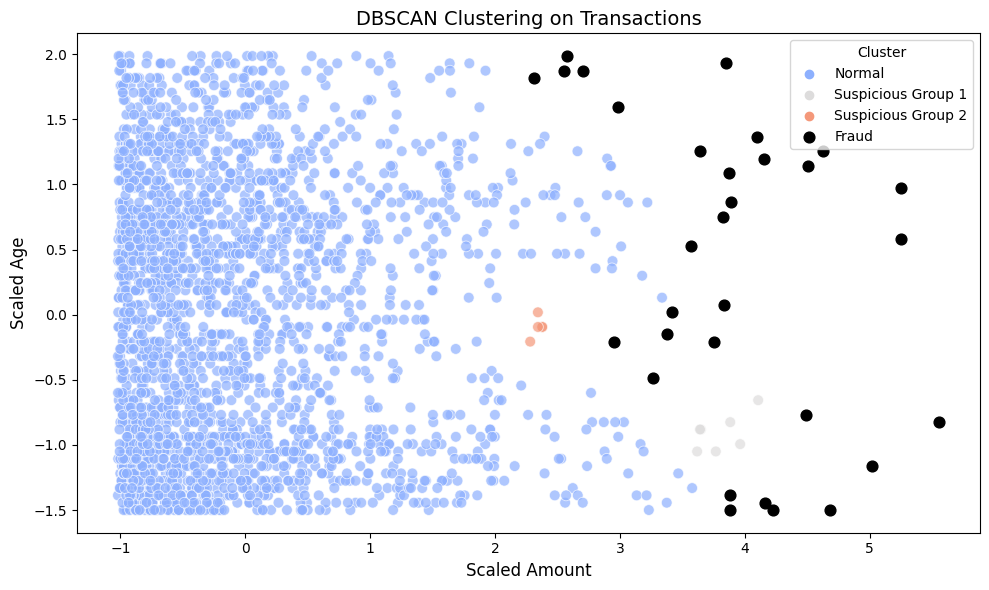

In [77]:
from sklearn.cluster import DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt

# Adjusted DBSCAN clustering with a refined eps value
dbscan = DBSCAN(eps=0.30, min_samples=5)  # Adjust eps based on k-distance elbow
dbscan_labels = dbscan.fit_predict(X_scaled)

unique_labels = np.unique(dbscan_labels)
print(f"Unique cluster labels: {unique_labels}")

# Add labels to the dataset
df['DBSCAN_Cluster'] = dbscan_labels

# Map the cluster labels to descriptive names
label_mapping = {-1: 'Fraud', 0: 'Normal', 1: 'Suspicious Group 1', 2: 'Suspicious Group 2'}
df['DBSCAN_Cluster'] = df['DBSCAN_Cluster'].map(label_mapping)

# Separate fraud data for custom styling
fraud_data = df[df['DBSCAN_Cluster'] == 'Fraud']
normal_data = df[df['DBSCAN_Cluster'] != 'Fraud']

# Count the number of frauds
num_frauds = (df['DBSCAN_Cluster'] == 'Fraud').sum()
print(f"Number of detected frauds: {num_frauds}")

# Plot normal and suspicious groups with a palette
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[normal_data.index, 0], y=X_scaled[normal_data.index, 1],
                hue=normal_data['DBSCAN_Cluster'], palette='coolwarm', s=60, alpha=0.7)

# Overlay fraud points as black spots
plt.scatter(X_scaled[fraud_data.index, 0], X_scaled[fraud_data.index, 1],
            color='black', s=60, label='Fraud', marker='o')

# Customize plot
plt.title('DBSCAN Clustering on Transactions', fontsize=14)
plt.xlabel('Scaled Amount', fontsize=12)
plt.ylabel('Scaled Age', fontsize=12)
plt.legend(title='Cluster', fontsize=10)
plt.tight_layout()
plt.show()


Summary for Cluster: Normal

                            mean   median          std     min       max
TransactionAmount     278.852301   205.58   255.217456    0.26   1342.25
CustomerAge            44.643580    45.00    17.759837   18.00     80.00
TransactionDuration   119.359660   112.00    69.784063   10.00    300.00
AccountBalance       5119.017849  4739.59  3905.013764  101.25  14977.99
LoginAttempts           1.125152     1.00     0.604658    1.00      5.00


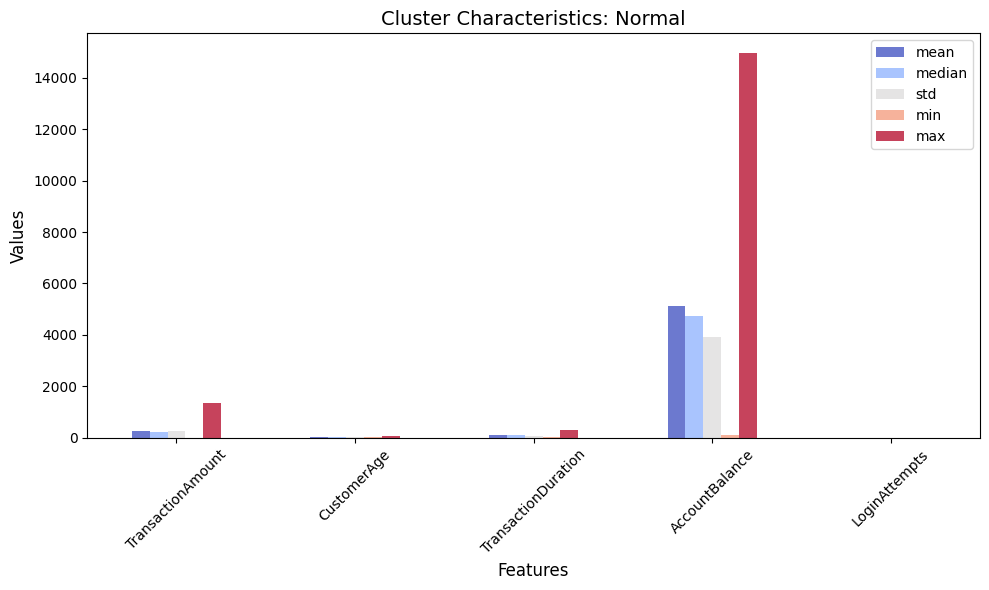


Summary for Cluster: Fraud

                            mean   median          std     min       max
TransactionAmount    1429.053548  1427.71   239.031724  973.39   1919.11
CustomerAge            51.000000    55.00    21.082378   18.00     80.00
TransactionDuration   131.580645   138.00    78.383576   21.00    297.00
AccountBalance       5168.486774  3910.59  3938.414261  859.86  13347.69
LoginAttempts           1.129032     1.00     0.562254    1.00      4.00


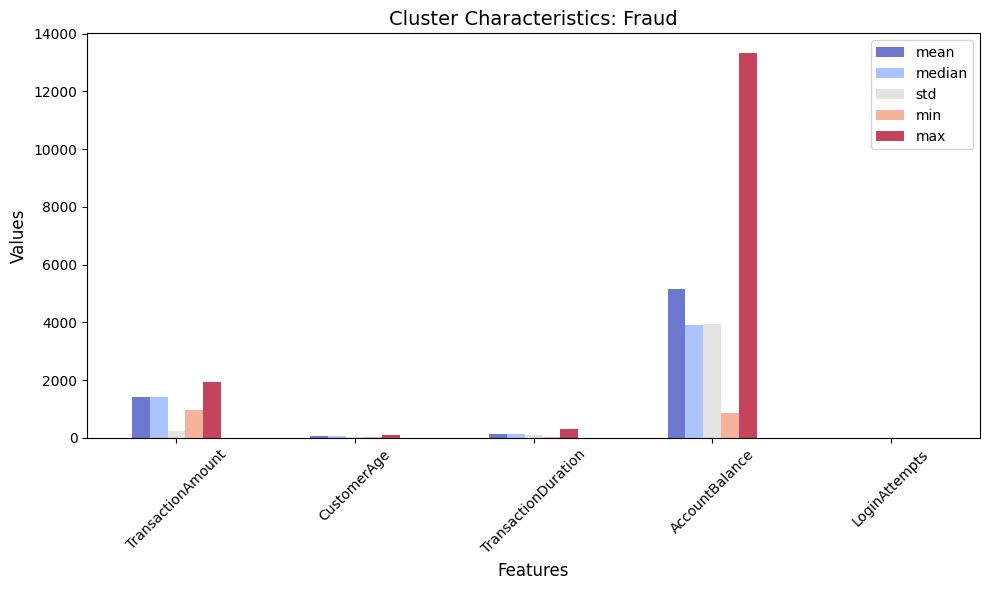


Summary for Cluster: Suspicious Group 1

                            mean   median          std      min      max
TransactionAmount    1408.165714  1397.59    54.605580  1353.93  1496.57
CustomerAge            28.571429    29.00     2.507133    26.00    33.00
TransactionDuration   100.428571   106.00    52.220230    20.00   171.00
AccountBalance       3144.371429  2429.68  2622.991639   969.06  7858.41
LoginAttempts           1.000000     1.00     0.000000     1.00     1.00


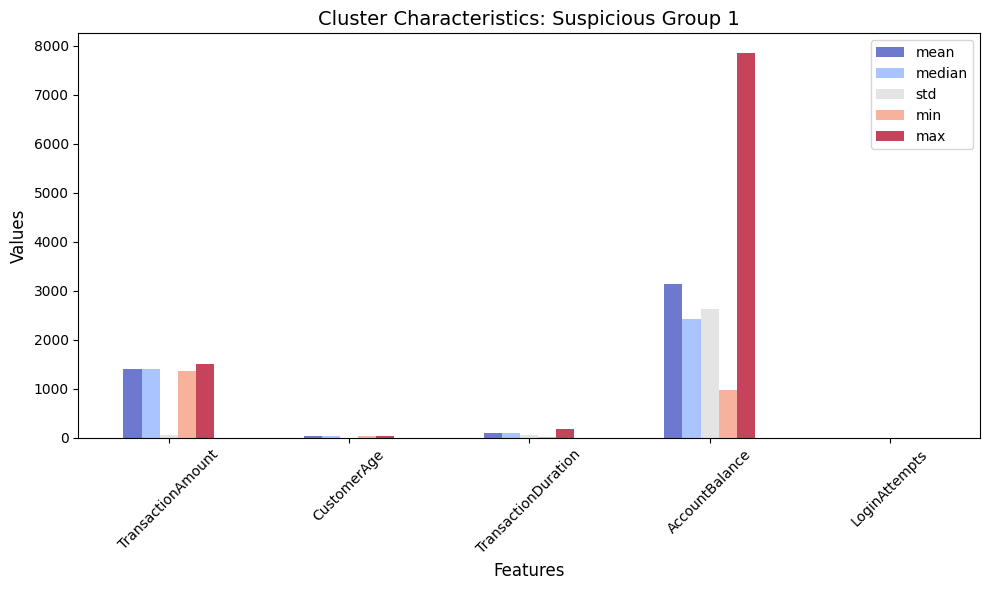


Summary for Cluster: Suspicious Group 2

                         mean   median          std     min      max
TransactionAmount     982.284   981.90    11.531029  963.77   992.17
CustomerAge            43.000    43.00     1.414214   41.00    45.00
TransactionDuration   212.600   234.00    73.094459  112.00   300.00
AccountBalance       5208.058  6215.96  3238.241548  602.36  9018.33
LoginAttempts           1.000     1.00     0.000000    1.00     1.00


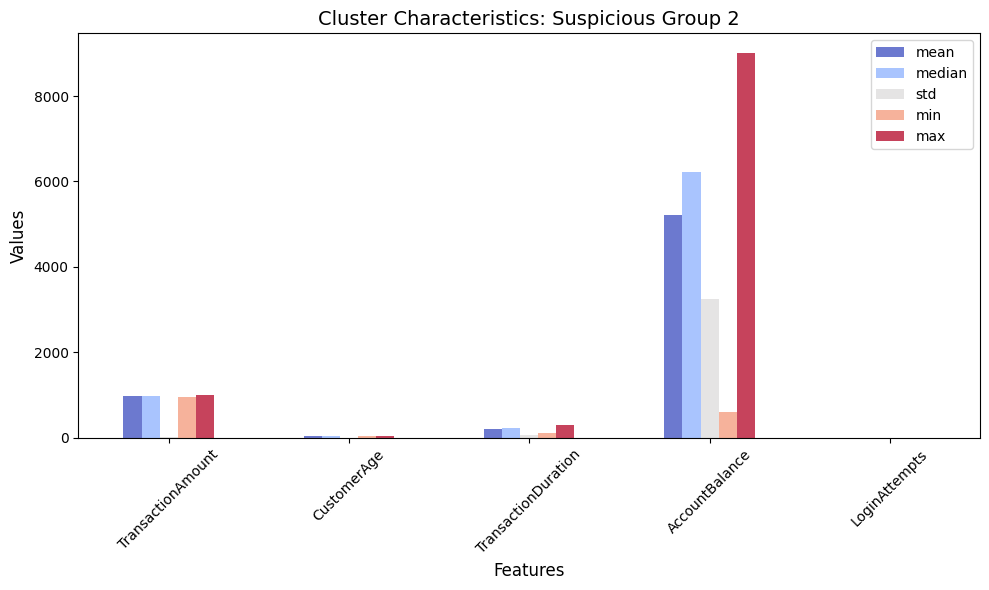

In [79]:
import matplotlib.pyplot as plt

# Select features for analysis
features_to_analyze = [
    'TransactionAmount', 'CustomerAge', 'TransactionDuration',
    'AccountBalance', 'LoginAttempts'
]

# Loop through each DBSCAN cluster and calculate summary statistics
for cluster in df['DBSCAN_Cluster'].unique():
    cluster_data = df[df['DBSCAN_Cluster'] == cluster]
    cluster_summary = cluster_data[features_to_analyze].agg(
        ['mean', 'median', 'std', 'min', 'max']
    ).T

    # Print summary statistics
    print(f"\nSummary for Cluster: {cluster}\n")
    print(cluster_summary)

    # Plotting summary for each cluster
    cluster_summary.plot(kind='bar', figsize=(10, 6), alpha=0.75, colormap='coolwarm')
    plt.title(f'Cluster Characteristics: {cluster}', fontsize=14)
    plt.ylabel('Values', fontsize=12)
    plt.xlabel('Features', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

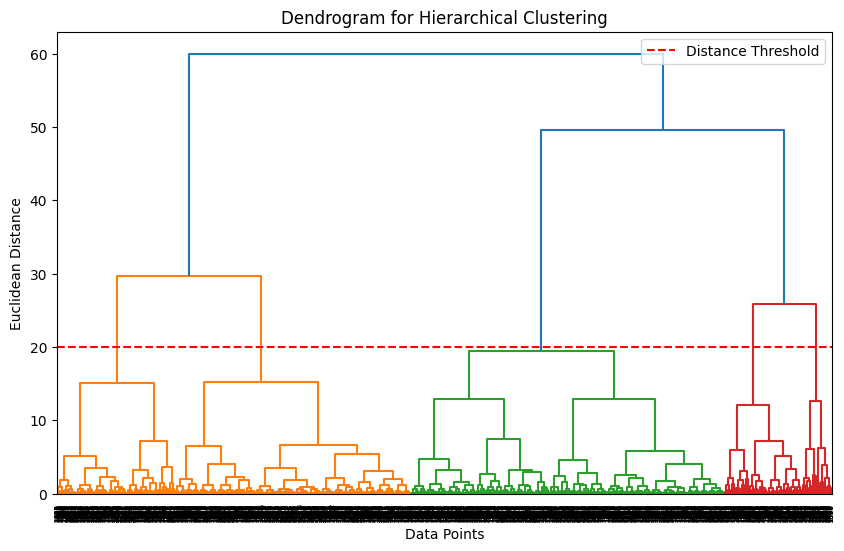

In [81]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import numpy as np
import matplotlib.pyplot as plt

# Perform hierarchical clustering
linkage_matrix = linkage(X_scaled, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Data Points')
plt.ylabel('Euclidean Distance')
plt.axhline(y=20, color='r', linestyle='--', label='Distance Threshold')  # Adjusted the threshold y to different values 10,20,25,18
plt.legend()
plt.show()

Cluster sizes:
Hierarchical_Cluster
0    1016
1     768
3     382
4     250
2      96
Name: count, dtype: int64


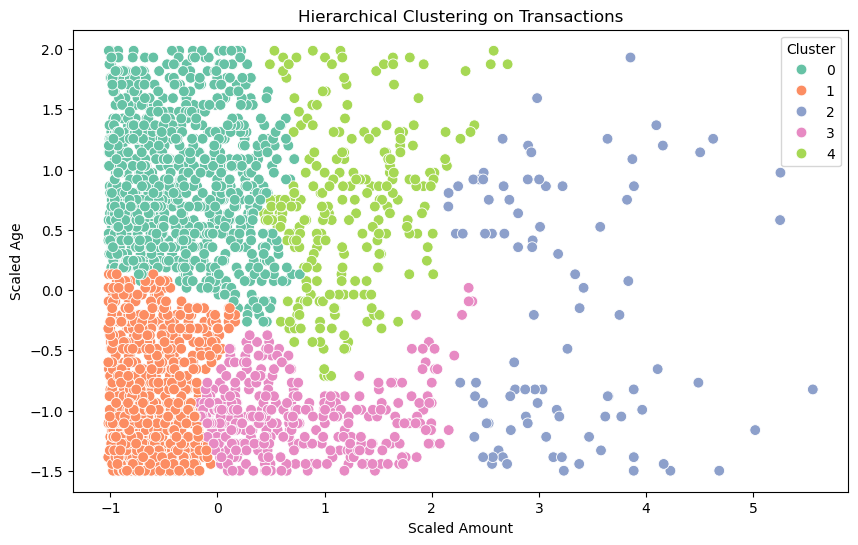

Number of clusters identified: 5


In [75]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns

# Hierarchical clustering using distance threshold
hierarchical = AgglomerativeClustering(distance_threshold=20, n_clusters=None, metric='euclidean', linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_scaled)

# Add labels to the dataset
df['Hierarchical_Cluster'] = hierarchical_labels

# Print the size of all clusters
cluster_sizes = df['Hierarchical_Cluster'].value_counts()
print("Cluster sizes:")
print(cluster_sizes)

# Plot with updated labels
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=df['Hierarchical_Cluster'], palette='Set2', s=60)
plt.title('Hierarchical Clustering on Transactions')
plt.xlabel('Scaled Amount')
plt.ylabel('Scaled Age')
plt.legend(title='Cluster')
plt.show()

# Count the number of clusters
print(f"Number of clusters identified: {len(set(hierarchical_labels))}")

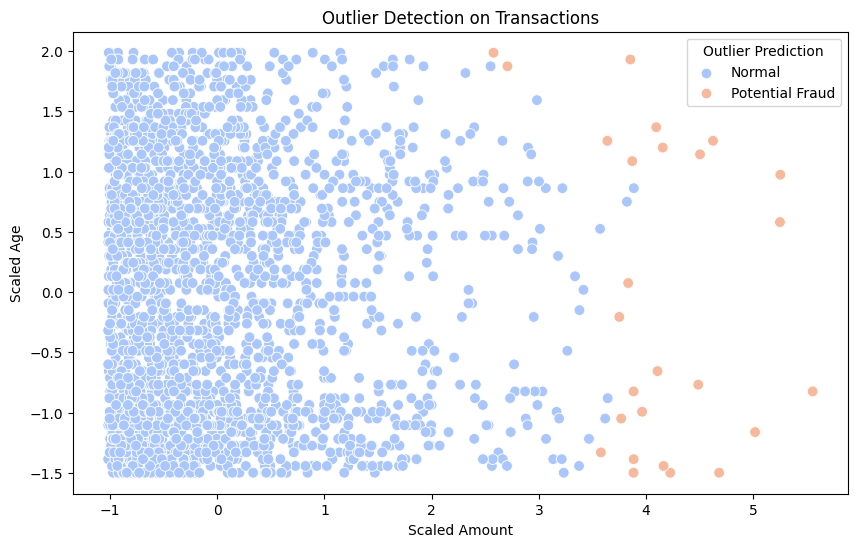

In [82]:
from sklearn.ensemble import IsolationForest

# Apply Isolation Forest to identify anomalies
iso_forest = IsolationForest(contamination=0.01, random_state=42)  # Set contamination rate to expected fraud rate
outlier_pred = iso_forest.fit_predict(X_scaled)

# Map the results (-1 for outliers, 1 for normal) to descriptive labels
outlier_mapping = {1: 'Normal', -1: 'Potential Fraud'}
df['Outlier_Prediction'] = pd.Series(outlier_pred).map(outlier_mapping)

# Plotting with isolation forest outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=df['Outlier_Prediction'], palette='coolwarm', s=60)
plt.title('Outlier Detection on Transactions')
plt.xlabel('Scaled Amount')
plt.ylabel('Scaled Age')
plt.legend(title='Outlier Prediction')
plt.show()


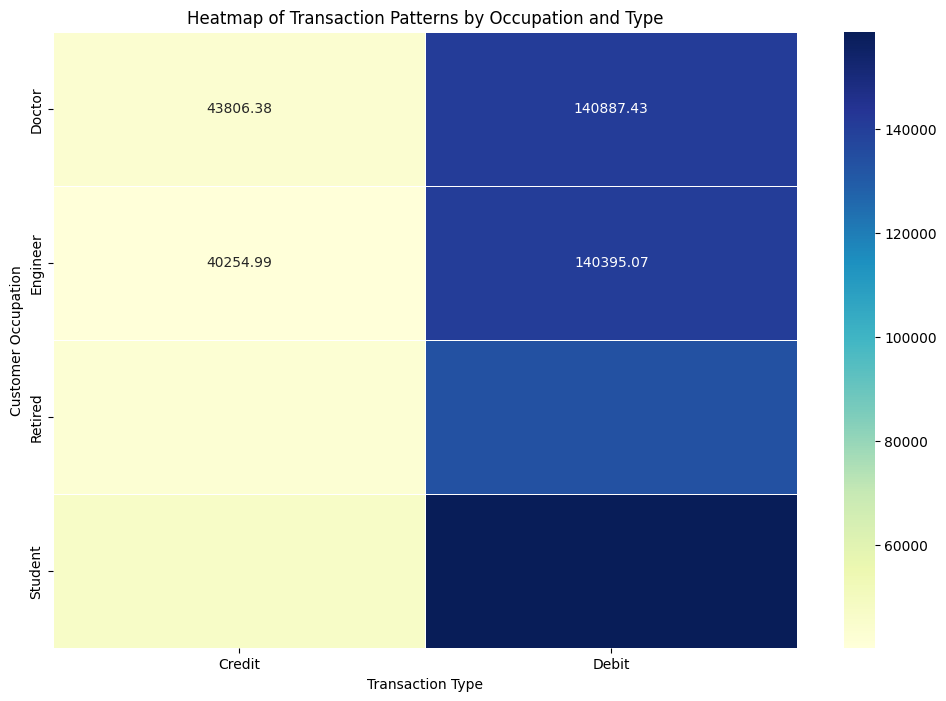

In [83]:
#Heat map of transaction patterns

transaction_pivot = pd.pivot_table(df, values='TransactionAmount', index='CustomerOccupation', columns='TransactionType', aggfunc='sum')

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(transaction_pivot, annot=True, fmt=".2f", cmap='YlGnBu', linewidths=.5)
plt.title('Heatmap of Transaction Patterns by Occupation and Type')
plt.xlabel('Transaction Type')
plt.ylabel('Customer Occupation')
plt.show()

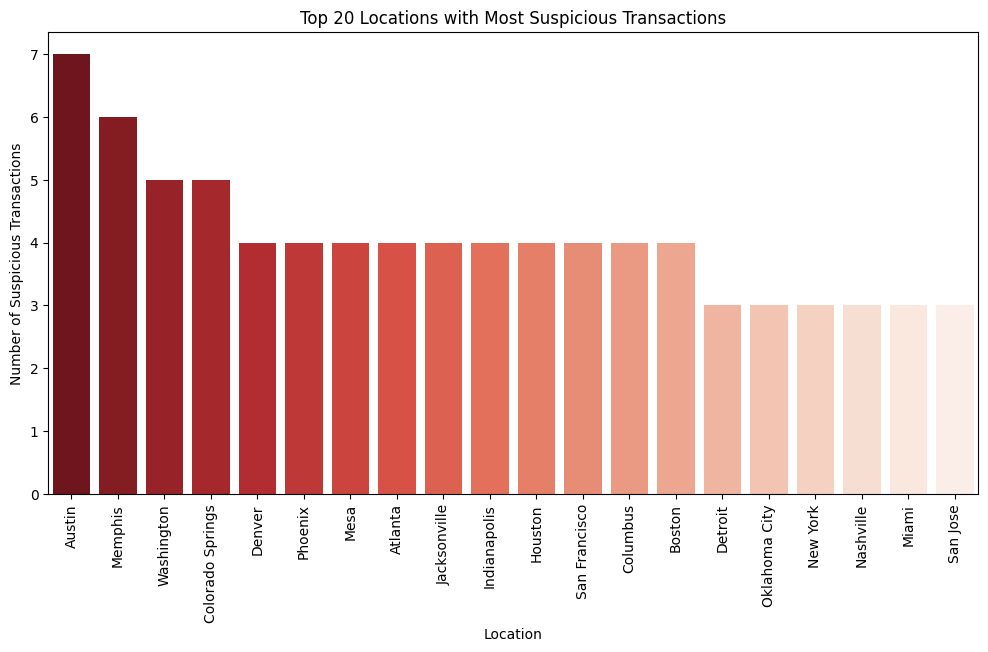

In [87]:
#Geographic distribution of suspicious activities

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group by location and count potential frauds
location_frauds = df.groupby('Location')['Potential_Fraud'].sum().sort_values(ascending=False)

# Plotting the top locations with the most suspicious transactions
plt.figure(figsize=(12, 6))
sns.barplot(x=location_frauds.index[:20], y=location_frauds.values[:20], palette='Reds_r')
plt.xticks(rotation=90)
plt.title('Top 20 Locations with Most Suspicious Transactions')
plt.xlabel('Location')
plt.ylabel('Number of Suspicious Transactions')
plt.show()

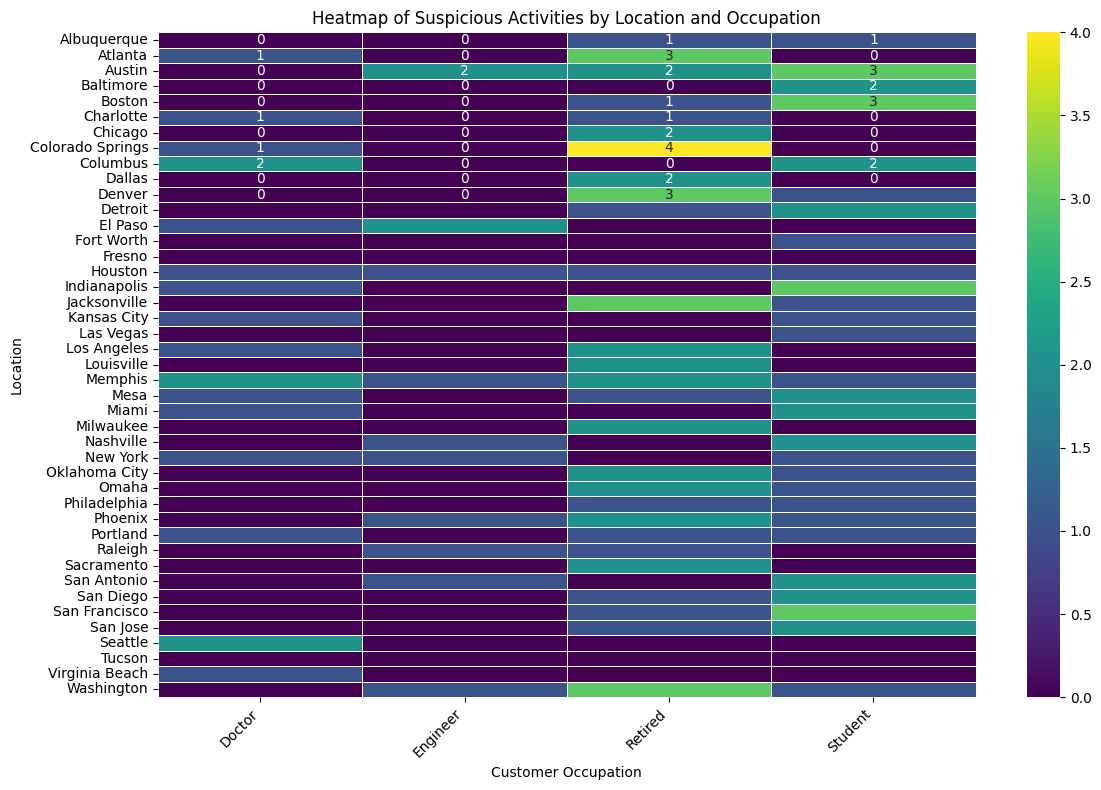

In [89]:
# prompt: Heatmap of Suspicious Activities by Location and Occupation

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame and it contains 'Location', 'CustomerOccupation', and 'Potential_Fraud' columns.
# Replace 'df' with the actual name of your DataFrame if it's different.

# Create a pivot table for the heatmap
heatmap_data = df.pivot_table(index='Location', columns='CustomerOccupation', values='Potential_Fraud', aggfunc='sum', fill_value=0)

# Plot the heatmap
plt.figure(figsize=(12, 8))  # Adjust figure size as needed
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt='d', linewidths=.5) # Use a suitable colormap
plt.title('Heatmap of Suspicious Activities by Location and Occupation')
plt.xlabel('Customer Occupation')
plt.ylabel('Location')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

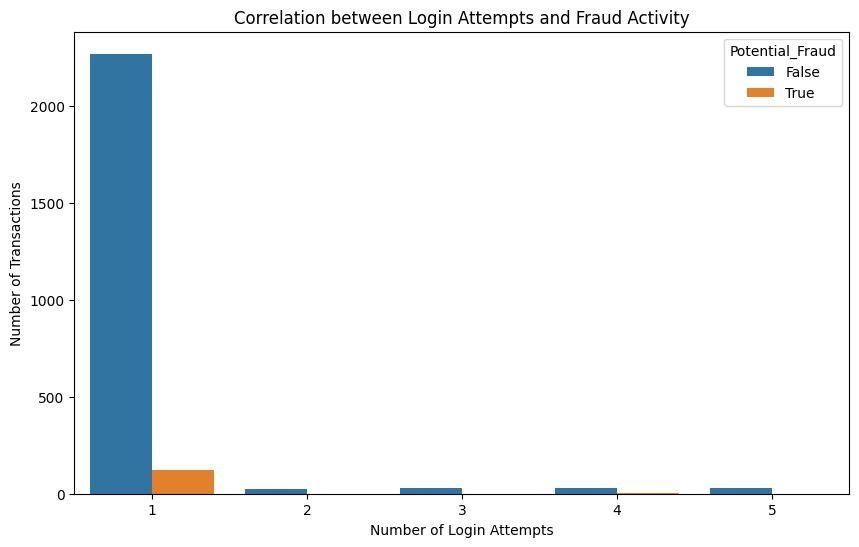

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(x='LoginAttempts', hue='Potential_Fraud', data=df)
plt.title('Correlation between Login Attempts and Fraud Activity')
plt.xlabel('Number of Login Attempts')
plt.ylabel('Number of Transactions')
plt.show()

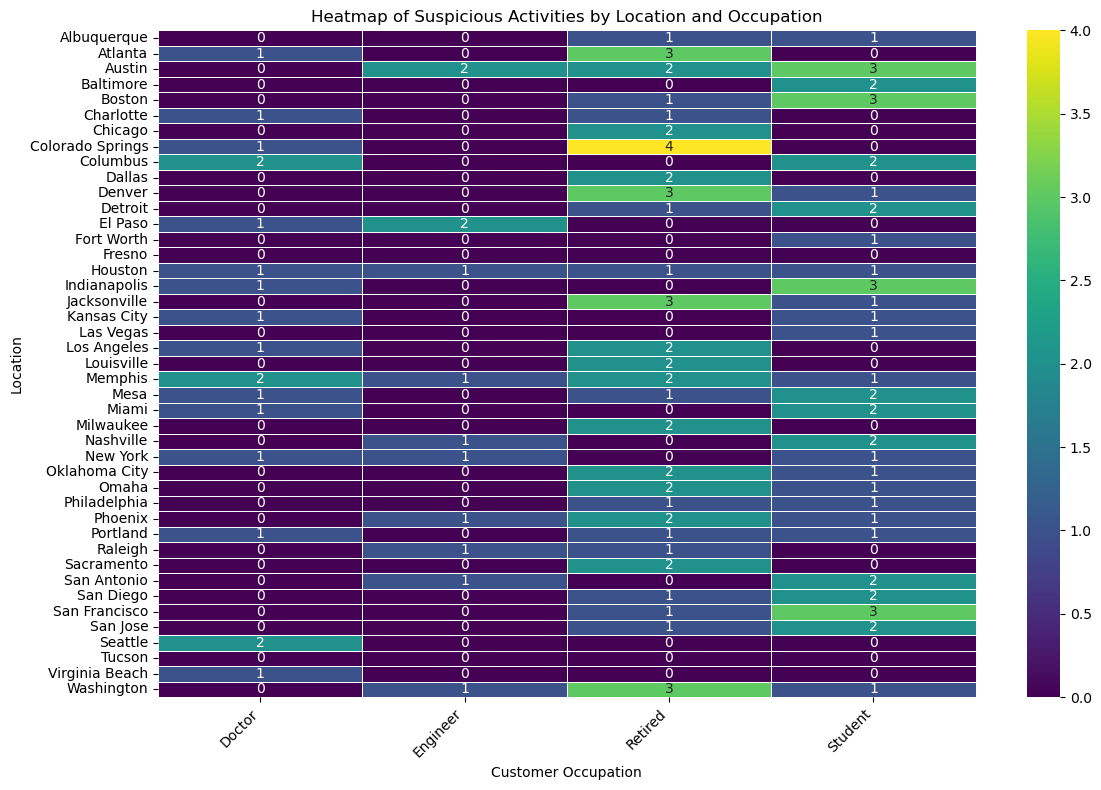

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame and it contains 'Location', 'CustomerOccupation', and 'Potential_Fraud' columns.
# Replace 'df' with the actual name of your DataFrame if it's different.

# Create a pivot table for the heatmap
heatmap_data = df.pivot_table(index='Location', columns='CustomerOccupation', values='Potential_Fraud', aggfunc='sum', fill_value=0)

# Plot the heatmap
plt.figure(figsize=(12, 8))  # Adjust figure size as needed
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt='d', linewidths=.5) # Use a suitable colormap
plt.title('Heatmap of Suspicious Activities by Location and Occupation')
plt.xlabel('Customer Occupation')
plt.ylabel('Location')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

Number of transactions with time difference of less than 1 hour: 16


TransactionID AccountID  TransactionAmount     TransactionDate  \
95        TX000096   AC00010             508.68 2023-06-26 16:16:50   
1258      TX001259   AC00020             603.23 2023-08-24 17:34:13   
2497      TX002498   AC00030             348.17 2023-05-10 17:56:31   
496       TX000497   AC00114             286.50 2023-10-23 16:58:04   
2341      TX002342   AC00144              97.73 2023-05-29 17:55:23   

     TransactionType    Location DeviceID      IP Address MerchantID Channel  \
95            Credit        Mesa  D000622  193.108.17.115       M048  Branch   
1258           Debit     Detroit  D000238  38.210.156.148       M017  Branch   
2497           Debit     El Paso  D000269   82.51.236.134       M072     ATM   
496           Credit      Boston  D000602  16.128.130.153       M097  Branch   
2341           Debit  Sacramento  D000038  135.29.211.116       M018  Branch   

      ...  AccountBalance PreviousTransactionDate  AgeGroup  DayOfWeek  \
95    ...         7708.41     2024-11-04 08:09:32       51+     Monday   
1258  ...          117.98     2024-11-04 08:08:18     26-35   Thursday   
2497  ...         1887.84     2024-11-04 08:11:06     18-25  Wednesday   
496   ...         8517.95     2024-11-04 08:09:17     26-35     Monday   
2341  ...         7885.21     2024-11-04 08:08:27       51+     Monday   

                     Coordinates KMeans_Cluster Potential_Fraud  \
95     (33.4151005, -111.831455)              0           False   
1258   (42.3315509, -83.0466403)              1           False   
2497  (31.7601164, -106.4870404)              2           False   
496     (42.3554334, -71.060511)              2           False   
2341   (38.5810606, -121.493895)              0           False   

     DBSCAN_Cluster Outlier_Prediction  TimeDifference  
95           Normal             Normal           505.0  
1258         Normal             Normal          2812.0  
2497         Normal             Normal           394.0  
496          Normal             Normal           451.0  
2341         Normal             Normal          2480.0  

[5 rows x 24 columns]

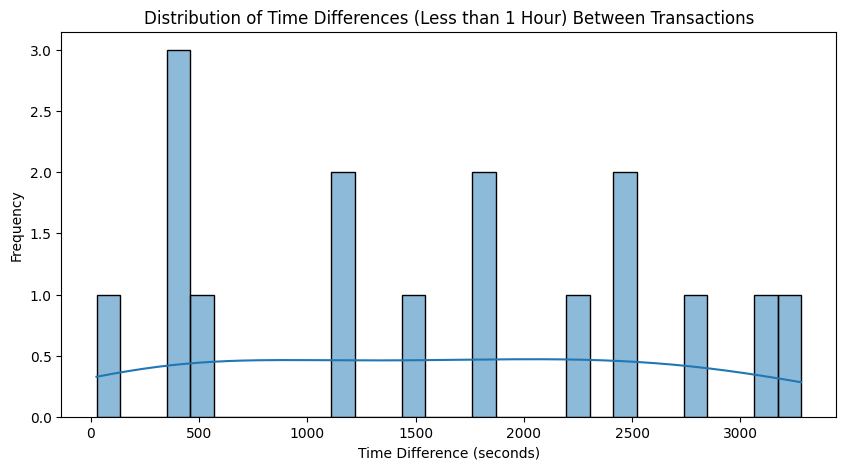

In [93]:
# Ensure TransactionDate is in datetime format
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

# Sort data by AccountID and TransactionDate for accurate time difference calculations
df_sorted = df.sort_values(by=['AccountID', 'TransactionDate'])

# Calculate time difference between consecutive transactions for each account
df_sorted['TimeDifference'] = df_sorted.groupby('AccountID')['TransactionDate'].diff().dt.total_seconds()

# Filter transactions with a time difference of less than 1 hour (3600 seconds)
rapid_transactions = df_sorted[df_sorted['TimeDifference'] <= 3600]

# Display the number of such transactions and a preview of the data
print(f"Number of transactions with time difference of less than 1 hour: {len(rapid_transactions)}")
display(rapid_transactions.head())

# Visualize the distribution of time differences for these transactions
plt.figure(figsize=(10, 5))
sns.histplot(rapid_transactions['TimeDifference'].dropna(), bins=30, kde=True)
plt.title('Distribution of Time Differences (Less than 1 Hour) Between Transactions')
plt.xlabel('Time Difference (seconds)')
plt.ylabel('Frequency')
plt.show()

In [95]:
pip install nbconvert

Note: you may need to restart the kernel to use updated packages.


In [97]:
!tlmgr install tcolorbox

tlmgr.pl: package repository https://mirror.marwan.ma/ctan/systems/texlive/tlnet (verified)


tlmgr itself needs to be updated.
Please do this via either
  tlmgr update --self
or by getting the latest updater for Unix-ish systems:
  https://mirror.ctan.org/systems/texlive/tlnet/update-tlmgr-latest.sh
and/or Windows systems:
  https://mirror.ctan.org/systems/texlive/tlnet/update-tlmgr-latest.exe
Then continue with other updates as usual.
tlmgr.pl: Terminating; please see warning above!


In [105]:
!jupyter nbconvert --to pdf votre_notebook.ipynb

This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePr

[NbConvertApp] WARNING | pattern 'votre_notebook.ipynb' matched no files


In [106]:
pip install nbconvert[webpdf]

Note: you may need to restart the kernel to use updated packages.


In [102]:
import pickle

# Sauvegarder le modèle
with open('dbscan_model.pkl', 'wb') as file:
    pickle.dump(dbscan, file)

print("Modèle DBSCAN sauvegardé avec succès.")

Modèle DBSCAN sauvegardé avec succès.
